<a href="https://colab.research.google.com/github/brainmentorspvtltd/IGDTU_PyTorchTraining/blob/main/IG_ImageProcessingPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# torchvision - dataset, models architectures and image transformation
# torchvision.dataset
# torchvision.models
# torchvision.transformers
# torchvision.utils.data.DataLoaders

In [1]:
# base package
import torch
# neural network package
from torch import nn
# torchvision from image processing
import torchvision
# to load dataset from torchvision
from torchvision import datasets
# to perform transform and augmentation
from torchvision.transforms import ToTensor
# to plot images data
import matplotlib.pyplot as plt

In [2]:
train_data = datasets.FashionMNIST(
    root="dataset", # location where data will be downloaded
    train = True, # to download training data
    download = True, # download data if it doesn't exists
    transform = ToTensor(), # convert images into Torch tensor
    target_transform = None
    )

test_data = datasets.FashionMNIST(
    root="dataset", # location where data will be downloaded
    train = False, # to download training data
    download = True, # download data if it doesn't exists
    transform = ToTensor(), # convert images into Torch tensor
    )

100%|██████████| 26421880/26421880 [00:03<00:00, 8447135.90it/s] 


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 136704.58it/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2648127.34it/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6328334.41it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



In [3]:
type(train_data)

torchvision.datasets.mnist.FashionMNIST

In [4]:
# will show number of images and dimension of images
train_data.data.shape

torch.Size([60000, 28, 28])

In [5]:
# target names / names of classes
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
img, target = train_data[5655]

In [7]:
target

7

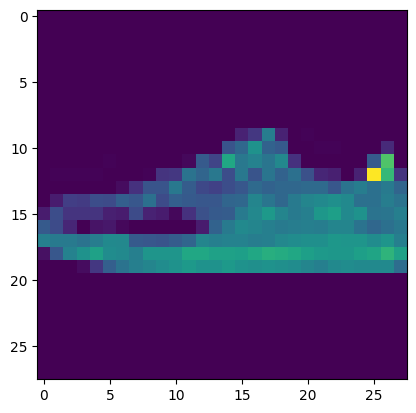

In [8]:
plt.imshow(img.squeeze())
plt.show()

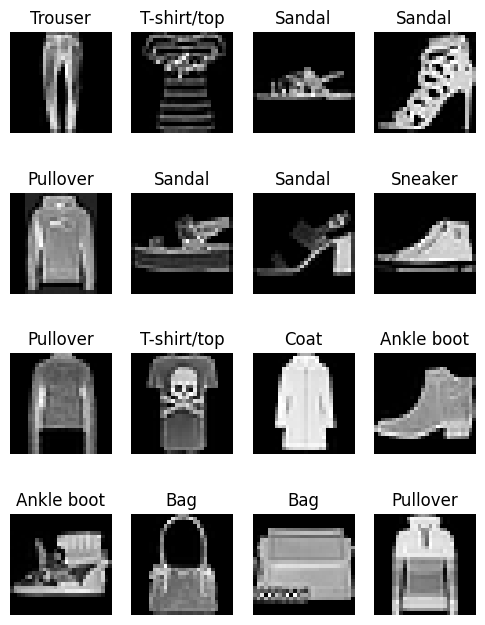

In [9]:
class_names = train_data.classes

fig = plt.figure(figsize=(6,8))
rows = 4
cols = 4
for i in range(1, rows * cols + 1):
  # get a random number between 0 to 60000
  random_index = torch.randint(0, len(train_data), size=[1]).item()
  # get image and target of that random index
  img, target = train_data[random_index]
  # add subplot for each image
  fig.add_subplot(rows, cols, i)
  # plot image using matplotlib, cmap - set color map as grayscale
  plt.imshow(img.squeeze(), cmap="gray")
  # add title on each subplot
  plt.title(class_names[target])
  # exclude x-axis and y-axis limits
  plt.axis(False)

In [10]:
# DataLoaders
# used to load data

# turns large dataset into smaller chunks known as batces or mini-batches
# generally we put chunk size of 32

In [11]:
60000 / 32

1875.0

In [12]:
from torch.utils.data import DataLoader

In [13]:
BATCH_SIZE = 32

train_dataLoader = DataLoader(train_data, # dataset that we to have convert into batches
                              batch_size=BATCH_SIZE, # batch size, how many samples per batch
                              shuffle=True) # shuffle data on every epoch

test_dataLoader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [14]:
# Build Base Model

In [15]:
class Model(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),   # Flatten - [1,28,28] -> [1, 28*28]
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [16]:
# input_shape = 784 - 28 * 28 = 784
# hidden_units = neurons in hidden layer
# output_shape = 10 - because we have 10 categories

model = Model(input_shape=784, hidden_units=64, output_shape=len(class_names))

In [18]:
model.to("cuda")

Model(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [19]:
# Evaluation metric
def accuracy(y_true, y_pred):
  # y_true = 1, y_pred = 1
  # y_true = 0, y_pred = 0
  correct_classification = torch.eq(y_true, y_pred).sum().item()
  acc = (correct_classification / len(y_pred)) * 100
  return acc

In [20]:
# because it's a multi-classification problem that's why we are using CrossEntropy
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [21]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  train_loss, train_acc = 0, 0
  model.to(device)

  for batch, (X,y) in enumerate(data_loader):
    X,y = X.to(device), y.to(device)
    
    # Feedforward
    y_pred = model(X)

    # Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy(y, y_pred.argmax(dim=1))
    # Backpropagate
    optimizer.zero_grad()
    # Loss Backward
    loss.backward()
    # optimizer step
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Acc : {train_acc:.3f} | Train Loss : {train_loss:.3f}\n")

def test_step(model, data_loader, loss_fn, accuracy, device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device)
      
      # Feedforward
      y_pred = model(X)

      # Calculate loss
      loss = loss_fn(y_pred, y)
      test_loss += loss
      test_acc += accuracy(y, y_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Acc : {test_acc:.3f} | Test Loss : {test_loss:.3f}\n")



In [22]:
# tqdm - used to show progress of loop
from tqdm import tqdm

epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n")
  train_step(model, train_dataLoader, loss_function, optimizer, accuracy, "cuda")
  test_step(model, test_dataLoader, loss_function, accuracy, "cuda")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 0
Train Acc : 66.422 | Train Loss : 0.998



 20%|██        | 1/5 [00:13<00:53, 13.38s/it]

Test Acc : 70.487 | Test Loss : 0.872

Epoch : 1
Train Acc : 71.387 | Train Loss : 0.840



 40%|████      | 2/5 [00:26<00:39, 13.08s/it]

Test Acc : 71.516 | Test Loss : 0.841

Epoch : 2
Train Acc : 71.935 | Train Loss : 0.817



 60%|██████    | 3/5 [00:39<00:25, 12.99s/it]

Test Acc : 71.645 | Test Loss : 0.847

Epoch : 3
Train Acc : 72.180 | Train Loss : 0.807



 80%|████████  | 4/5 [00:51<00:12, 12.90s/it]

Test Acc : 70.337 | Test Loss : 0.876

Epoch : 4
Train Acc : 72.487 | Train Loss : 0.796



100%|██████████| 5/5 [01:04<00:00, 12.91s/it]

Test Acc : 71.556 | Test Loss : 0.834

